# Assigning chiral information with SMARTS templates
> "How to transform an achiral molecule into a chiral based on a chiral template in RDKit"

- toc: true
- badges: true
- comments: true
- categories: [cheminformatics]

## Introduction

Molecules can be described with undefined stereochemistry, for example by not specifiying whether a certain stereocenter is R or S. Here, we will investigate how we can fix the stereochemistry of such molecules based on a SMARTS template that matches (parts of) the molecule. This could be a useful trick for example with SMILES strings generated with [STONED SELFIES](https://github.com/aspuru-guzik-group/stoned-selfies) that do not (yet) have chiral information.

## Code

We import the usual RDKit packages and turn on stereo annotion of the images.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.ipython_useSVG=True 

First we will generate the molecule without chiral information

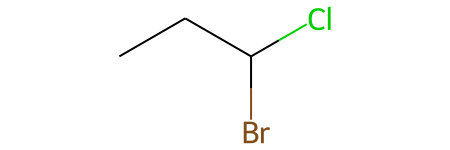

In [2]:
smiles = "C(Cl)(Br)CC"
mol = Chem.MolFromSmiles(smiles)
display(mol)

Our goal is to convert this molecule into the reference below, which has a R configuration of the stereocenter.

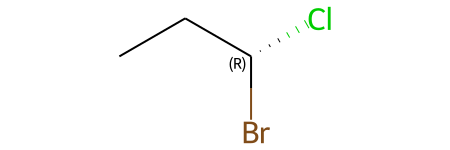

In [3]:
smiles_ref = "Br[C@@H](Cl)CC"
mol_ref = Chem.MolFromSmiles(smiles_ref)
display(mol_ref)

We construct a SMARTS pattern with chiral information that will match the stereocenter. RDKit's visualization of SMARTS patterns is quite limited, and we could instead use SMARTSView to get a better [view](https://smarts.plus/smartsview/4768ff0bcafc2fd7217e1f53a3dd2c0cd13fbf17c3b44dd6594b0998480e).

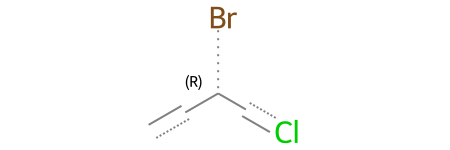

In [4]:
smarts = "[C][C@@H]([Br])[Cl]"
pattern = Chem.MolFromSmarts(smarts)
display(pattern)

We use the `GetSubstructMatch` method to obtain the atom indices of `mol` that match the pattern. They will be listed in the order of the atoms in the SMARTS pattern. The display of the Mol object is automatically updated to show the matched atoms.

Matched indices: (3, 0, 2, 1)


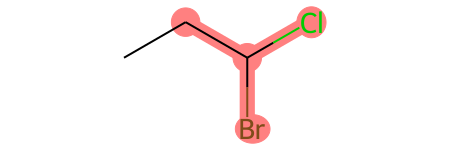

In [5]:
match = mol.GetSubstructMatch(pattern)
print("Matched indices:", match)
display(mol)

The key feature for determining chiral tags in RDKit is the order of the bonds in the Mol object. We will therefore use the following strategy:

1. Reorder the bonds in the Mol object so that they match the order in the SMARTS pattern
2. Set the chiral tags of each matched atom so that they match the SMARTS pattern

First, we find the indices of the bonds in `mol` that match those in `pattern`:

In [6]:
indices_matched = []
for bond in pattern.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    bond = mol.GetBondBetweenAtoms(match[i], match[j])
    indices_matched.append(bond.GetIdx())
print("Matched bond indices:", indices_matched)

Matched bond indices: [2, 1, 0]


Then we reorder the bond indices from `mol` so that the matched bonds (a) come before the unmatched ones and (b) have the same order as in `pattern`

In [7]:
indices_all = list(range(mol.GetNumBonds()))
indices_rest = [i for i in indices_all if i not in indices_matched]
indices_new = indices_matched + indices_rest
print("Rest of bond indices:", indices_rest)
print("New bond index order:", indices_new)

Rest of bond indices: [3]
New bond index order: [2, 1, 0, 3]


To actually reorder the bonds, we need to create an editable `RWMol` object. We (a) remove all the bonds and then (b) add them back together in the new order.

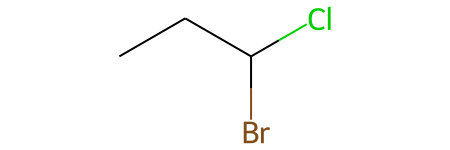

In [8]:
rw_mol = Chem.RWMol(mol)

bond_info = []
for bond in list(rw_mol.GetBonds()):
    bond_info.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()))
    rw_mol.RemoveBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

for i in indices_new:
    rw_mol.AddBond(*bond_info[i])
display(rw_mol)

Finally, we set the chiral tags of each matched atom to that of the SMARTS pattern and recover a new `Mol` object that matches the stereochemistry that we want.

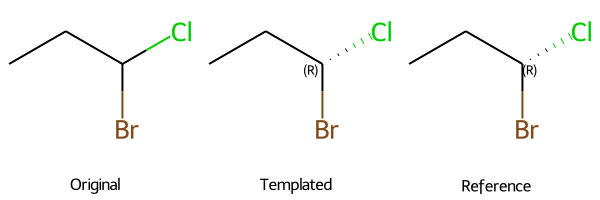

In [9]:
for i, atom in enumerate(pattern.GetAtoms()):
    chiral_tag = atom.GetChiralTag()
    rw_mol.GetAtomWithIdx(match[i]).SetChiralTag(chiral_tag)
    
mol_new = rw_mol.GetMol()
Chem.SanitizeMol(mol_new)
Chem.AssignCIPLabels(mol_new)

Chem.Draw.MolsToGridImage([mol, mol_new, mol_ref], legends=["Original", "Templated", "Reference"], molsPerRow=3, useSVG=True)

## Function

Finally we can put everything together in one function:

In [10]:
def apply_chiral_template(mol, pattern):
    # Apply SMARTS pattern to Mol
    match = mol.GetSubstructMatch(pattern)
    
    # Find indices of matched bonds in Mol
    indices_matched = []
    for bond in pattern.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond = mol.GetBondBetweenAtoms(match[i], match[j])
        indices_matched.append(bond.GetIdx())
        
    # Reorder bond indices to match SMARTS pattern
    indices_all = list(range(mol.GetNumBonds()))
    indices_rest = [i for i in indices_all if i not in indices_matched]
    indices_new = indices_matched + indices_rest
    
    # Create new Mol. Delete and re-add bonds in new order
    rw_mol = Chem.RWMol(mol)
    
    bond_info = []
    for bond in list(rw_mol.GetBonds()):
        bond_info.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType()))
        rw_mol.RemoveBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
    
    for i in indices_new:
        rw_mol.AddBond(*bond_info[i])
    
    # Set chiral tags from template to new Mol
    for i, atom in enumerate(pattern.GetAtoms()):
        chiral_tag = atom.GetChiralTag()
        rw_mol.GetAtomWithIdx(match[i]).SetChiralTag(chiral_tag)
        
    # Recover new Mol
    new_mol = rw_mol.GetMol()
    Chem.SanitizeMol(new_mol)
    
    return new_mol

## More complex example

Now we will use the function on a more complex example with four stereocenters. Note that R and S labels depend on the CIP order of the substituents, which is not defined in terms of the wildcard atom "*" 

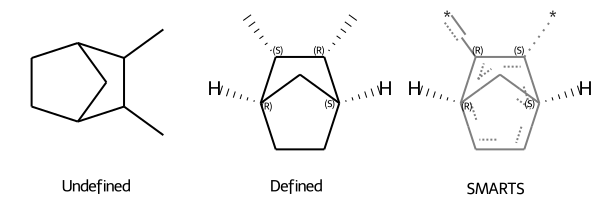

In [11]:
smiles = "CC1C(C)C2CCC1C2"
mol = Chem.MolFromSmiles(smiles)

smiles_ref = "C[C@@H]1[C@H](C)[C@H]2CC[C@@H]1C2"
mol_ref = Chem.MolFromSmiles(smiles_ref)

smarts = "[*][C@@H]1[C@H]([*])[C@H]2CC[C@@H]1C2"
pattern = Chem.MolFromSmarts(smarts)
Chem.SanitizeMol(pattern) # Needed to avoid bug in MolsToGridImage

Chem.Draw.MolsToGridImage([mol, mol_ref, pattern], legends=["Undefined", "Defined", "SMARTS"], useSVG=True)

To get the right CIP labels, we need to apply the function `AssignCIPLabels` but that should not be crucial except for visualization.

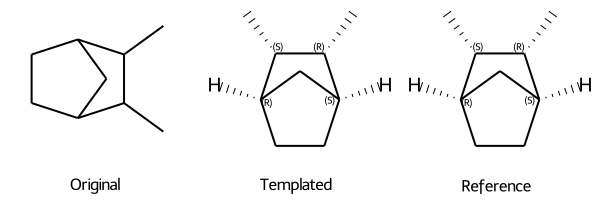

In [12]:
mol_new = apply_chiral_template(mol, pattern)
Chem.AssignCIPLabels(mol_new)
Chem.Draw.MolsToGridImage([mol, mol_new, mol_ref], legends=["Original", "Templated", "Reference"], molsPerRow=3, useSVG=True)

## Licensing and citation

[![License: MIT](https://img.shields.io/badge/License-MIT-yellow.svg)](https://opensource.org/licenses/MIT)

Code free to use under an MIT license.

For citation, use webpage address and access date.